## DATA VALUES

<Figure size 640x480 with 0 Axes>

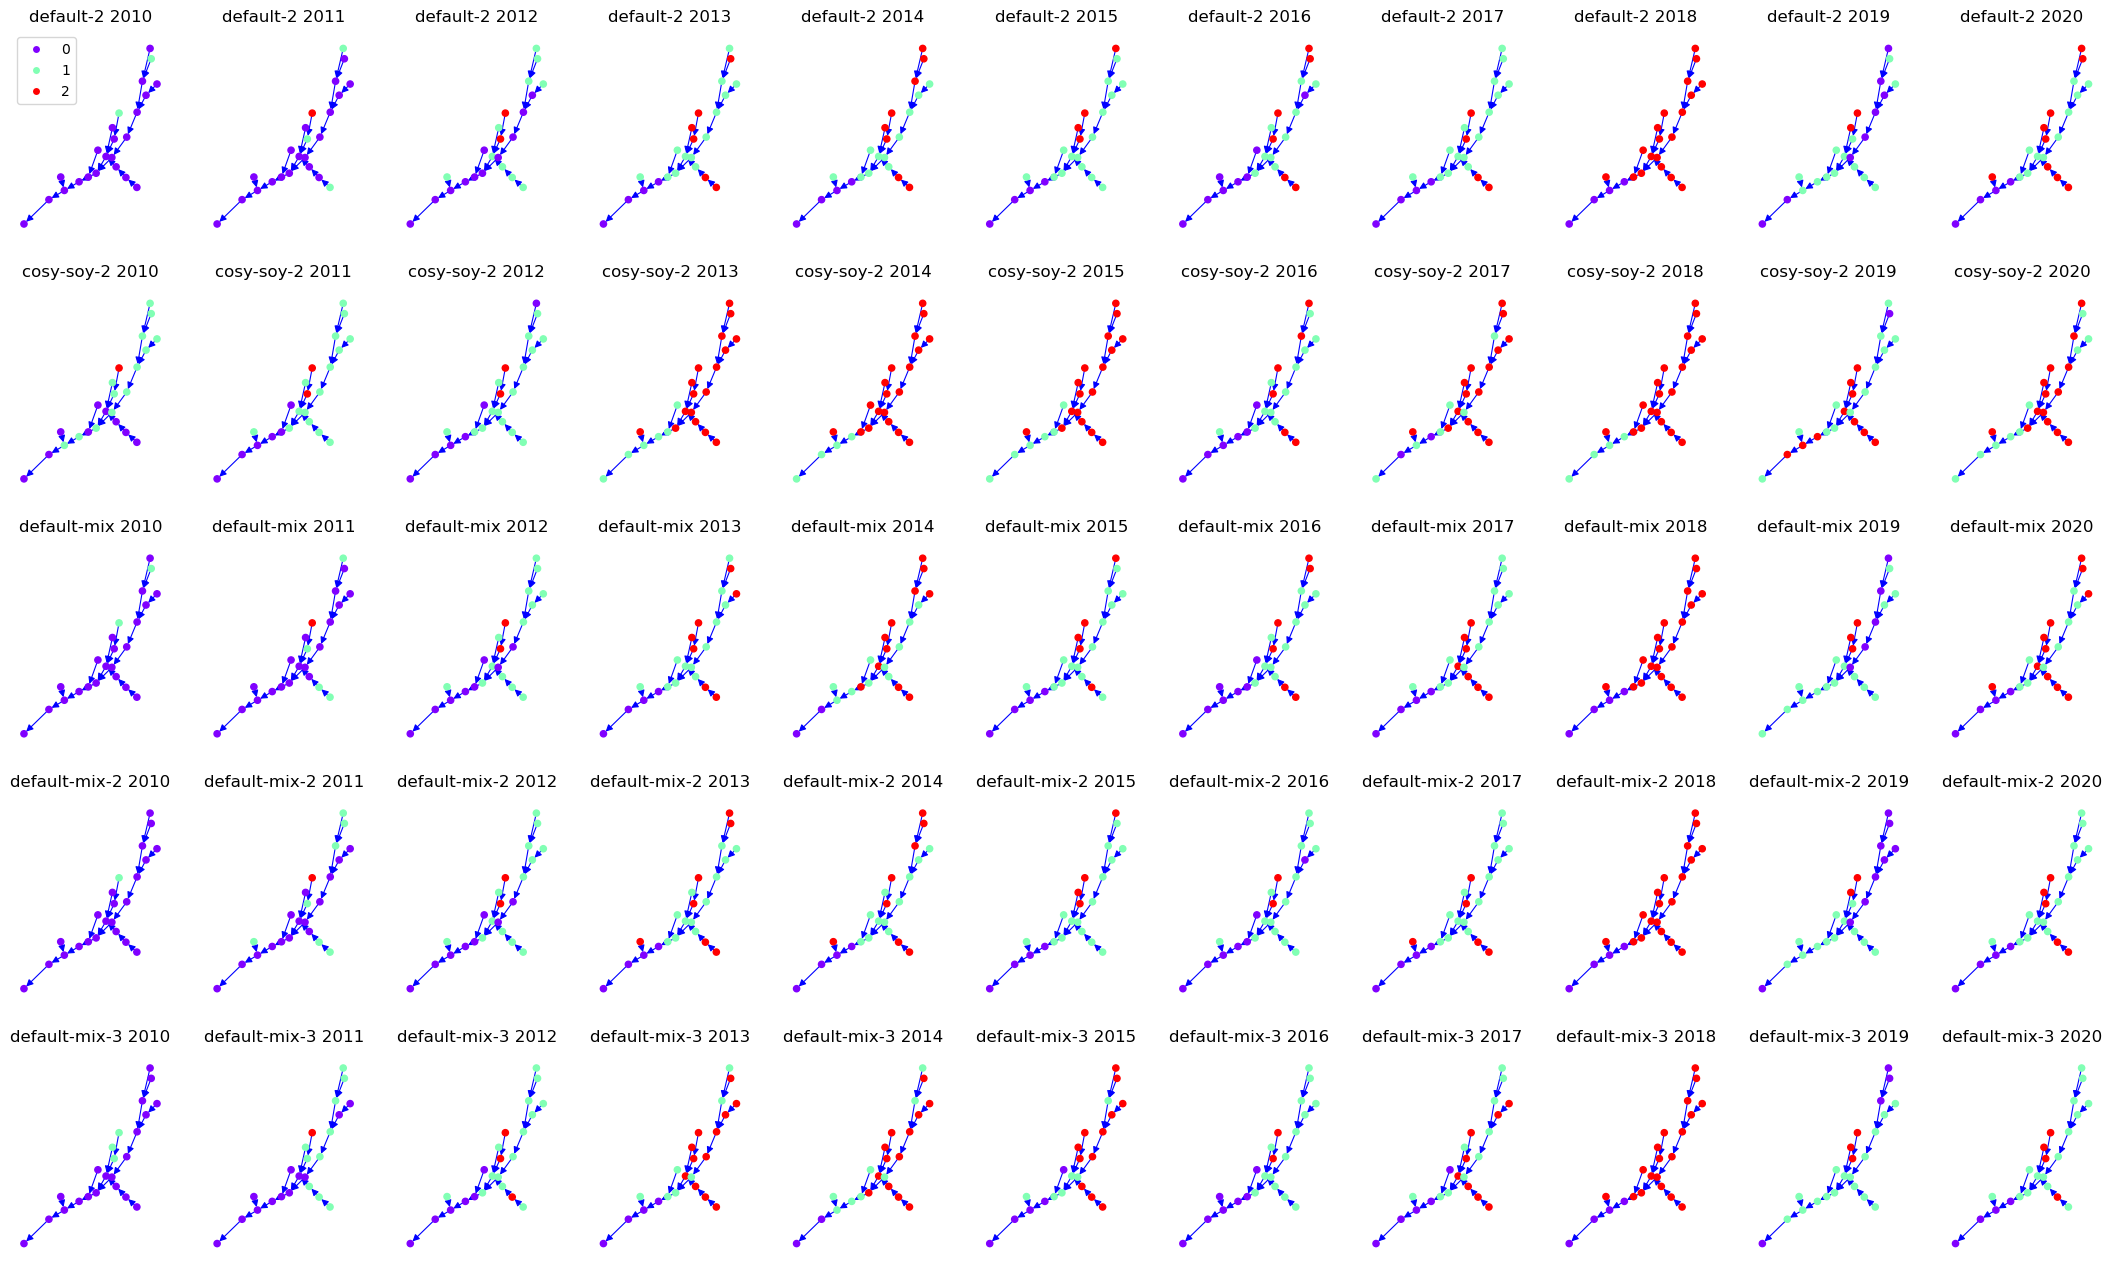

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx
import matplotlib.cm as cm
import pickle
import os
import torch

def plot_ax(G, values, title, num_bins, ax, ix):
    max_value = int(max(values))
    min_value = int(min(values))
    set_values = list(range(min_value, max_value+1))
    color = cm.rainbow(np.linspace(0, 1, num_bins))
    node_colors = []
    for idx, value in enumerate(values):
        node_colors.append(color[int(value)])
    
    pos = nx.spring_layout(G, iterations=100, seed=5)
    nx.draw(G, pos=pos, with_labels=False, node_size=20, node_color=node_colors, edge_color='blue', width=0.8, arrowsize=10, ax=ax)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color[idx], label=value) for idx, value in enumerate(list(range(num_bins)))]
    if ix == (0, 0):
        ax.legend(handles=handles)
    # ax.axis('equal')
    ax.set_title(title)

with open(os.getcwd()+'/data/train_graphs_all.pkl', 'rb') as f:
    train_graphs = pickle.load(f)
with open(os.getcwd()+'/data/test_graphs_all.pkl', 'rb') as f:
    test_graphs = pickle.load(f)
with open(os.getcwd()+'/data/val_graphs_all.pkl', 'rb') as f:
    val_graphs = pickle.load(f)

# scenarios = ["default-2", "soy-3", "corn-3", "pasture-3", 'cosy-3', "pasture-corn", "soy-corn-2", "cosy-corn-2", "pasture-soy-2", "pasture-cosy-2", "cosy-soy-2", "default-mix", "default-mix-2", "default-mix-3"]
scenarios = ["default-2", "cosy-soy-2", "default-mix", "default-mix-2", "default-mix-3"]

fig = plt.figure(); plt.clf()
fig, ax = plt.subplots(len(scenarios), len(list(range(2010, 2021))), figsize=(27, 16))
main_nodes = range(1, train_graphs[0][0]['sub'].x.shape[0]+1)

years = list(range(2010, 2021))
counter = 0
for s, scenario in enumerate(scenarios):
    for yc, year in enumerate(years):
        for idx, (graph, G, y, m) in enumerate(test_graphs+train_graphs+val_graphs):
            if graph.scenario == scenario and y == year:
                sub_graph = G.subgraph(main_nodes)
                ix = np.unravel_index(counter, ax.shape)
                counter += 1
                plot_ax(sub_graph, graph['sub'].y.cpu().detach().numpy(), f"{graph.scenario} {y}", 3, ax[ix], ix)



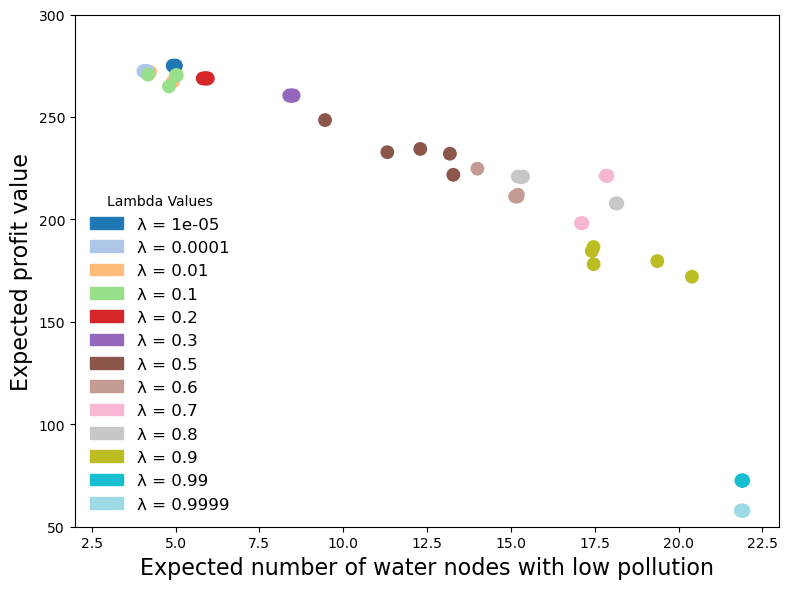

In [2]:
# LAMBDA VALUES DICTIONARIES
lambda_map = {1: 0.1, 2: 0.2, 3:0.3, 4:0.4, 5:0.5, 6:0.6, 7:0.05, 8:0.01, 9:0.001, 10:0.8, 11:0.7, 12:0.9, 13:0.99, 14:0.999, 15:0.9999, 16:0.0001, 17:0.00001}

# COST FOR CROP
cost_map = {0: 5.0, 1: 2.0, 2:1.0, 3:4.0}

prob_cost = []
data = train_graphs[0][0].clone() # random graph to be overwritten

folder_path = "results/results_lambda"
prefix = "txt_graph_" 

files = [f for f in os.listdir(folder_path) if f.startswith(prefix) ]

for file in files:    
    with open(f"results/results_lambda/{file}", "r") as f:
        exp = int(file.split('_')[2])
        rest = int(file.split('_')[-1][0])
        lines = f.readlines()
        tot_out = 0
        crop_counts = {0: 0, 1: 0, 2: 0, 3: 0}
        for i in range(2, len(lines)-2):
            crop_type = int(lines[i].split(':')[1].strip())
            area = data['hru_agr'].x[int(lines[i].split(':')[0].strip())-23][-1].item()
            tot_out += cost_map[crop_type]*area
            crop_counts[crop_type] += area

        if tot_out == 0: print(f"txt_graph_{exp}_{rest}.txt")
        prob_cost.append((lambda_map[exp], tot_out, float(lines[-1].split(',')[1].split(']')[0].strip()), crop_counts))


x_values = [item[2] * 23.2 for item in prob_cost]
y_values = [item[1] for item in prob_cost]
labels = [str(item[0]) for item in prob_cost]

unique_labels = sorted(set(labels), key=lambda x: float(x))

colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

color_map = dict(zip(unique_labels, colors))
point_colors = [color_map[label] for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, color=point_colors, s=80)

plt.xlabel("Expected number of water nodes with low pollution", fontsize=16)
plt.ylabel("Expected profit value", fontsize=16)

plt.xlim(2, 23)
plt.ylim(50,300)

legend_handles = [
    mpatches.Patch(color=color_map[label], label=f"λ = {label}") 
    for label in unique_labels
]
plt.legend(handles=legend_handles, title="Lambda Values", 
           loc="best",
           fontsize=12,
           frameon=False)

plt.tight_layout() 
plt.show()

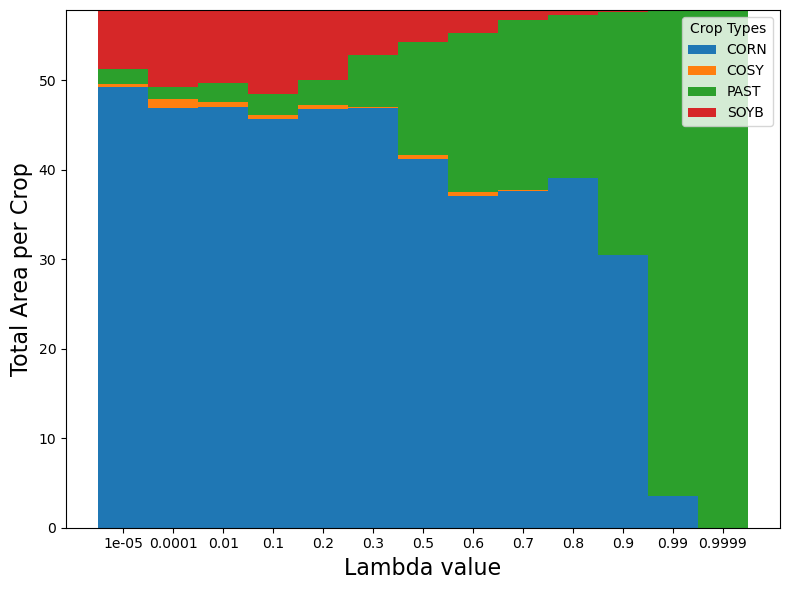

In [3]:
lambda_data = {}
for entry in prob_cost:
    lam, tot_out, expected_clean, crop_counts = entry
    if lam not in lambda_data:
        lambda_data[lam] = {0: 0, 1: 0, 2: 0, 3: 0, 'num_restart': 0}
    for crop in [0, 1, 2, 3]:
        lambda_data[lam][crop] += crop_counts[crop]
    lambda_data[lam]['num_restart'] += 1

lambdas = sorted(lambda_data.keys())
lambdas_col = list(range(len(lambdas)))

crop0 = [lambda_data[lam][0] / lambda_data[lam]['num_restart'] for lam in lambdas]
crop1 = [lambda_data[lam][1] / lambda_data[lam]['num_restart'] for lam in lambdas]
crop2 = [lambda_data[lam][2] / lambda_data[lam]['num_restart'] for lam in lambdas]
crop3 = [lambda_data[lam][3] / lambda_data[lam]['num_restart'] for lam in lambdas]

plt.figure(figsize=(8,6))
p0 = plt.bar(lambdas_col, crop0, label='CORN', width=1)
p1 = plt.bar(lambdas_col, crop1, bottom=crop0, label='COSY', width=1)
p2 = plt.bar(lambdas_col, crop2, bottom=np.array(crop0)+np.array(crop1), label='PAST', width=1)
p3 = plt.bar(lambdas_col, crop3, bottom=np.array(crop0)+np.array(crop1)+np.array(crop2), label='SOYB', width=1)

plt.xticks(lambdas_col, lambdas)
plt.xlabel('Lambda value', fontsize=16)
plt.ylabel('Total Area per Crop', fontsize=16)
plt.legend(title="Crop Types")
plt.tight_layout()
plt.show()


# visualize results

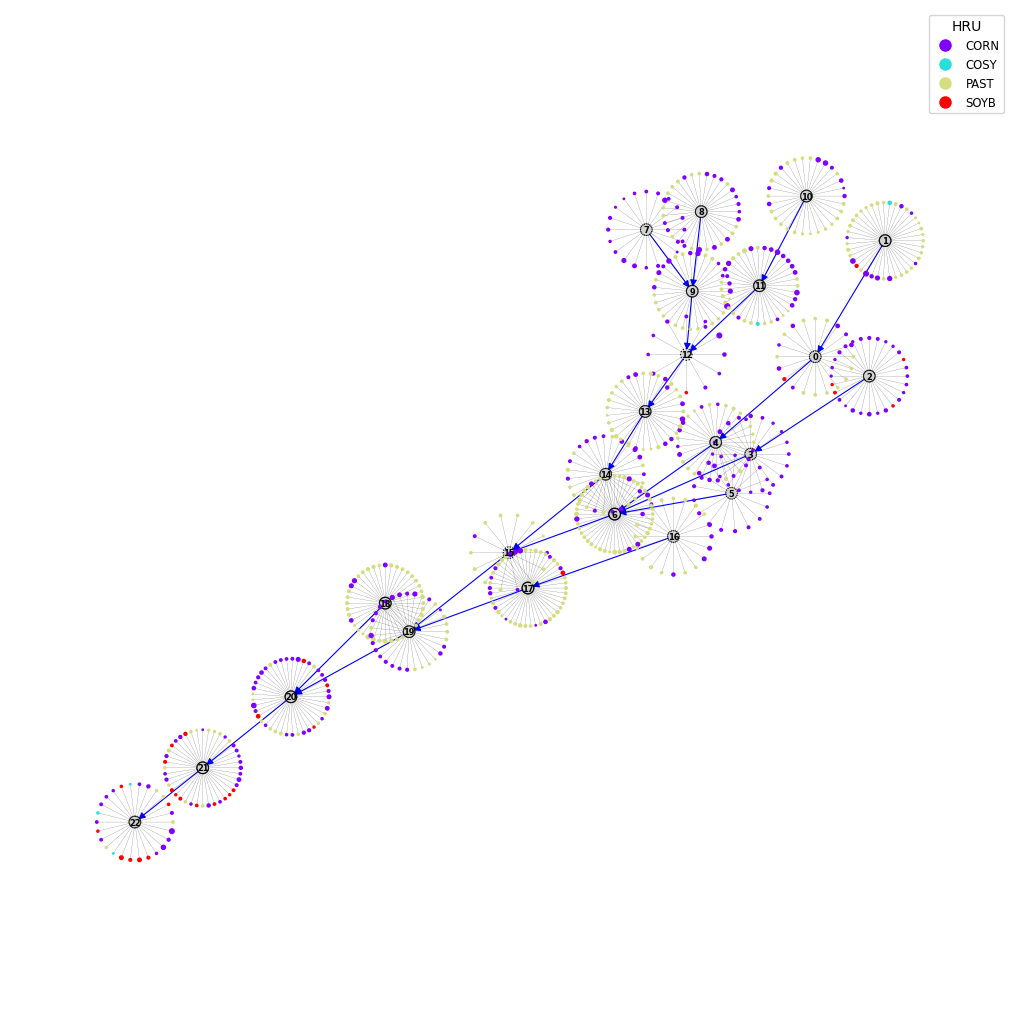

In [4]:
data = train_graphs[0][0].clone() # random graph to be overwritten

with open(f"results/results_lambda/txt_graph_11_2.txt", "r") as f: # results for a particular lamda and restart
    lines = f.readlines()
    sub = 0
    for i in range(2, len(lines)-2):
        new_value = torch.zeros(4)
        crop = int(lines[i].split(':')[1].strip())
        new_value[crop] = 1.0
        data['hru_agr'].x[sub][:4] = new_value
        sub += 1

def display_values(data):
    G = nx.DiGraph()

    for edge in data.edge_index_dict[('sub', 'to', 'sub')].t():
        G.add_node(edge[0].item(), node_type='sub')
        G.add_node(edge[1].item(), node_type='sub')
        G.add_edge(edge[0].item(), edge[1].item(), color='blue', weight=0.8, arrowsize=10)

    for edge in data.edge_index_dict[('hru_agr', 'to', 'sub')].t():
        G.add_node(edge[1].item()+data['sub'].x.shape[0], node_type='hru_agr')
        G.add_edge(edge[0].item()+data['sub'].x.shape[0], edge[1].item(), color='black', weight=0.1, arrowsize=3)


    main_nodes = range(0, data['sub'].x.shape[0])
    sub_graph = G.subgraph(main_nodes)
    pos = nx.spring_layout(sub_graph, seed=888, iterations=100)

    neighbors = {} 
    for node in main_nodes:
        neighbors[node] = []

    for node in G.nodes():
            if node not in main_nodes:
                for neighbor in G.neighbors(node):
                    neighbors[neighbor].append(node)
    radius = 0.08
    for node in main_nodes:
        num_neighbors = len(neighbors[node])
        for i, neighbor in enumerate(neighbors[node]):
            pos[neighbor] = [pos[node][0] + radius * np.cos(2 * np.pi * (i + 1) / num_neighbors), pos[node][1] + radius * np.sin(2 * np.pi * (i + 1) / num_neighbors)]

    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    arrow_sizes = [G[u][v]['arrowsize'] for u,v in edges]
    labels = nx.get_node_attributes(G, 'label')

    luse_unique = ['CORN', 'COSY', 'PAST', 'SOYB']

    colors_ = cm.rainbow(np.linspace(0, 1, len(luse_unique)))
    colors_map = {hru: colors_[i] for i, hru in enumerate(luse_unique)}
    color_to_index = {c: i for i,c in enumerate(luse_unique)}

    hru_colors = []
    for hru in data['hru_agr'].x:
        hru_colors.append(colors_map[luse_unique[np.argmax(hru[:4]).item()]])

    for i in range(1, data['sub'].x.shape[0]+1):
        hru_colors.insert(i-1, 'lightgrey')

    node_sizes = []
    for node in G.nodes:
        if int(node) in main_nodes:
            node_sizes.append(40)
        else:
            node_sizes.append(30*data['hru_agr'].x[int(node)-data['sub'].x.shape[0]][-1].item()+1)
            

    plt.figure(figsize=(10, 10))
    nx.draw(G, pos=pos, with_labels=True, labels=labels, node_size=node_sizes, node_color=hru_colors, font_size=6, font_weight='light', edge_color=colors, width=weights, arrowsize=arrow_sizes)
    nx.draw_networkx_labels(G, pos, labels={n: n for n in main_nodes}, font_size=6, font_weight='bold')
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_[i], markersize=10, label=hru) for i, hru in enumerate(luse_unique)], title='HRU', loc='upper right', fontsize='small')
    plt.axis('equal')
    plt.show()

display_values(data)

# distribution for a given lambda value

In [5]:
data = train_graphs[0][0].clone() # random graph to be overwritten

subs = list(range(data['sub'].x.shape[0]))
sub_data = {s: [] for s in subs}
luse_unique = ['CORN', 'COSY', 'PAST', 'SOYB']

for i in range(1,5):
    new_data = data.clone()
    with open(f"results/results_lambda/txt_graph_{12}_{i}.txt", "r") as f:
        lines = f.readlines()
        sub = 0
        for i in range(2, len(lines)-2):
            new_value = torch.zeros(4)
            crop = int(lines[i].split(':')[1].strip())
            new_value[crop] = 1.0
            new_data['hru_agr'].x[sub][:4] = new_value
            sub += 1

    for s in range(new_data['sub'].x.shape[0]):
        hrus = new_data['hru_agr', 'to', 'sub'].edge_index[0][new_data['hru_agr', 'to', 'sub'].edge_index[1]==s].numpy()
        count_values = dict.fromkeys(luse_unique, 0)
        for hru in hrus:
            count_values[luse_unique[np.argmax(new_data['hru_agr'].x[hru][:5]).item()]] += new_data['hru_agr'].x[hru][-1].item()
        sub_data[s].append(count_values)


for sub, observations in sub_data.items():
    print(f"Sub {sub}:")
    for crop in luse_unique:
        crop_counts = [obs[crop] for obs in observations]
        mean_val = np.mean(crop_counts)
        std_val = np.std(crop_counts)
        print(f"  {crop}: Mean = {mean_val:.2f}, Std = {std_val:.2f}")
    print("-" * 30)

Sub 0:
  CORN: Mean = 1.39, Std = 0.37
  COSY: Mean = 0.00, Std = 0.00
  PAST: Mean = 0.21, Std = 0.37
  SOYB: Mean = 0.00, Std = 0.00
------------------------------
Sub 1:
  CORN: Mean = 2.57, Std = 0.72
  COSY: Mean = 0.02, Std = 0.02
  PAST: Mean = 0.44, Std = 0.76
  SOYB: Mean = 0.05, Std = 0.04
------------------------------
Sub 2:
  CORN: Mean = 1.79, Std = 0.00
  COSY: Mean = 0.00, Std = 0.00
  PAST: Mean = 0.00, Std = 0.00
  SOYB: Mean = 0.00, Std = 0.00
------------------------------
Sub 3:
  CORN: Mean = 1.51, Std = 0.00
  COSY: Mean = 0.00, Std = 0.00
  PAST: Mean = 0.00, Std = 0.00
  SOYB: Mean = 0.00, Std = 0.00
------------------------------
Sub 4:
  CORN: Mean = 0.31, Std = 0.13
  COSY: Mean = 0.00, Std = 0.00
  PAST: Mean = 1.88, Std = 0.13
  SOYB: Mean = 0.00, Std = 0.00
------------------------------
Sub 5:
  CORN: Mean = 1.30, Std = 0.00
  COSY: Mean = 0.00, Std = 0.00
  PAST: Mean = 0.00, Std = 0.00
  SOYB: Mean = 0.00, Std = 0.00
------------------------------
Sub 

NODE: 0 std: 0.9137662899333088
NODE: 1 std: 1.0
NODE: 2 std: 0.0014684689964365603
NODE: 3 std: 0.0
NODE: 4 std: 0.23598671478748837
NODE: 5 std: 0.0
NODE: 6 std: 0.13177742592725747
NODE: 7 std: 0.010355441997195137
NODE: 8 std: 0.08945181383805674
NODE: 9 std: 0.21103995810462117
NODE: 10 std: 0.09461463348430824
NODE: 11 std: 0.45860786400046616
NODE: 12 std: 0.0
NODE: 13 std: 0.13833282104113293
NODE: 14 std: 0.23351357926095567
NODE: 15 std: 0.0
NODE: 16 std: 0.23613348550010643
NODE: 17 std: 0.0980380177182161
NODE: 18 std: 0.07156092844120572
NODE: 19 std: 0.08111458495350529
NODE: 20 std: 0.15260363137132643
NODE: 21 std: 0.22507412666781787
NODE: 22 std: 0.2858319166045747


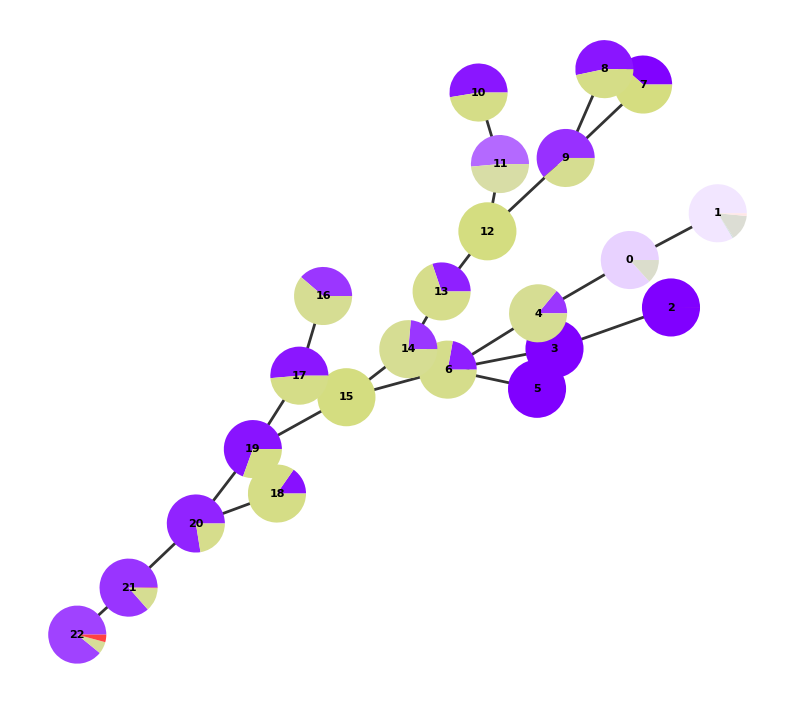

In [6]:
from matplotlib.patches import Wedge
import matplotlib.colors as mcolors


# Function to draw a pie chart at a given position
def draw_pie(ax, center, ratios, size, colors):
    start_angle = 0
    for ratio, color in zip(ratios, colors):
        angle = ratio * 360
        wedge = Wedge(center, size, start_angle, start_angle + angle,
                      facecolor=color, edgecolor='white', lw=0.0)
        ax.add_patch(wedge)
        start_angle += angle

def display_values_with_pies(data, sub_data):
    G = nx.DiGraph()

    for edge in data.edge_index_dict[('sub', 'to', 'sub')].t():
        G.add_node(edge[0].item(), node_type='sub')
        G.add_node(edge[1].item(), node_type='sub')
        G.add_edge(edge[0].item(), edge[1].item(), color='black', weight=0.8, arrowsize=10)

    main_nodes = list(range(0, data['sub'].x.shape[0]))
    sub_graph = G.subgraph(main_nodes)
    pos = nx.spring_layout(sub_graph, seed=888, iterations=100)

    luse_unique = ['CORN', 'COSY', 'PAST', 'SOYB']
    colors_ = cm.rainbow(np.linspace(0, 1, len(luse_unique)))
    colors_map = {crop: colors_[i] for i, crop in enumerate(luse_unique)}
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]
    edge_weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=2, alpha=0.8)

    nx.draw_networkx_labels(G, pos, labels={n: n for n in main_nodes}, font_size=8, font_weight='bold', ax=ax)

    # Compute the standar variation based on the ratios for each node.
    # For each node, first aggregate counts to compute ratios for the pie
    node_stds = {}
    node_ratios = {}  # store ratios for later drawing
    for node in main_nodes:
        observations = sub_data[node]
        
        # Compute aggregated counts to draw the pie chart later
        aggregated_counts = {crop: sum(obs[crop] for obs in observations) for crop in luse_unique}
        total = sum(aggregated_counts.values())
        if total == 0:
            continue
        aggregated_ratio = [aggregated_counts[crop] / total for crop in luse_unique]
        node_ratios[node] = aggregated_ratio
        
        # Compute the ratio vector for each observation
        ratio_vectors = []
        for obs in observations:
            obs_total = sum(obs[crop] for crop in luse_unique)
            if obs_total == 0:
                continue
            ratio_vectors.append([obs[crop] / obs_total for crop in luse_unique])
        
        # If we have ratio vectors from restarts, compute stds per crop and average them
        if ratio_vectors:
            ratio_vectors = np.array(ratio_vectors)  
            crop_stds = np.std(ratio_vectors, axis=0)
            node_stds[node] = np.mean(crop_stds)
    
    max_std = max(node_stds.values()) if node_stds else 0

    for node in main_nodes:
        if node not in node_ratios:
            continue
        ratios = node_ratios[node]
        std_factor = node_stds[node] / max_std if max_std > 0 else 0
        print(f"NODE: {node} std: {std_factor}")
        adjusted_colors = []
        for crop in luse_unique:
            base_color = colors_map[crop]
            r, g, b, a = mcolors.to_rgba(base_color)
            hsv = mcolors.rgb_to_hsv(np.array([[r, g, b]]))[0]
            new_saturation = hsv[1] * (1 - 0.9 * std_factor)
            new_color = mcolors.hsv_to_rgb(np.array([[hsv[0], new_saturation, hsv[2]]]))[0]
            adjusted_colors.append(new_color)
            
        draw_pie(ax, pos[node], ratios, size=0.08, colors=adjusted_colors)
    
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()

display_values_with_pies(new_data, sub_data)
